In [111]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
!ls "/content/drive/MyDrive/Colab Notebooks/Breast Cancer Patients MRI's/train"



Healthy  Sick


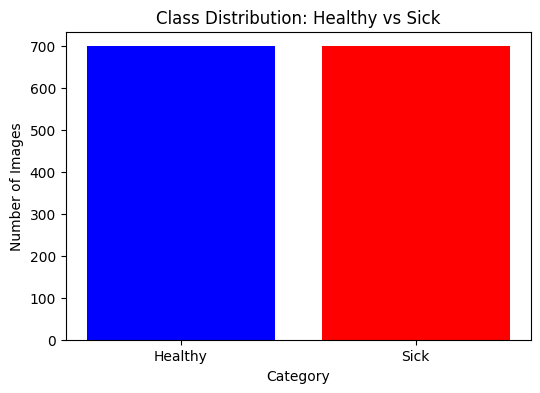

In [80]:
train_dir = "/content/drive/MyDrive/Colab Notebooks/Breast Cancer Patients MRI's/train"
categories = ['Healthy', 'Sick']

image_counts = {}
image_sizes = []
avg_color = {"Healthy": [], "Sick": []}

for category in categories:
    folder_path = os.path.join(train_dir, category)
    image_counts[category] = len(os.listdir(folder_path))
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        with Image.open(img_path) as img:
            image_sizes.append(img.size)
            img_array = np.array(img) / 255.0
            avg_color[category].append(img_array.mean(axis=(0, 1)))

plt.figure(figsize=(6, 4))
plt.bar(image_counts.keys(), image_counts.values(), color=['blue', 'red'])
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.title("Class Distribution: Healthy vs Sick")
plt.show()


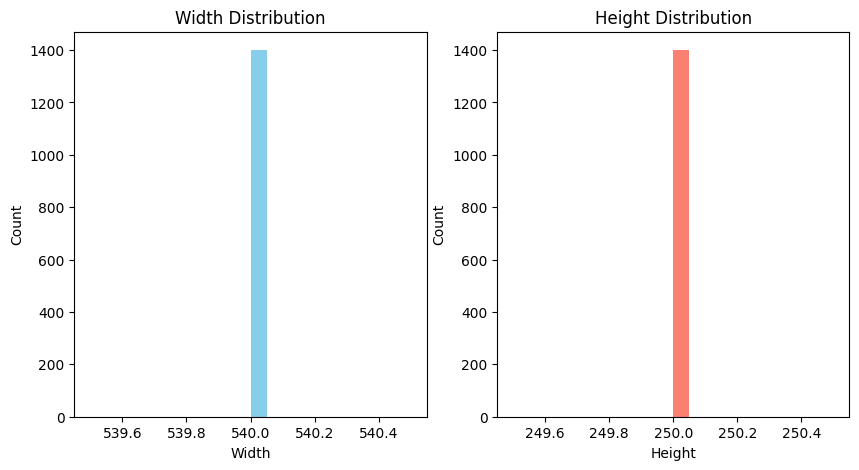

In [81]:
width, height = zip(*image_sizes)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(width, bins=20, color='skyblue')
plt.title('Width Distribution')
plt.xlabel('Width')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(height, bins=20, color='salmon')
plt.title('Height Distribution')
plt.xlabel('Height')
plt.ylabel('Count')
plt.show()

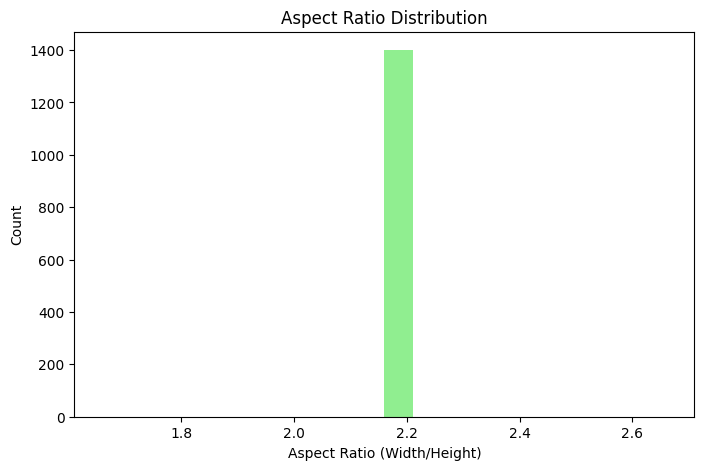

In [82]:
aspect_ratios = [w / h for w, h in image_sizes]
plt.figure(figsize=(8, 5))
plt.hist(aspect_ratios, bins=20, color='lightgreen')
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Count')
plt.show()

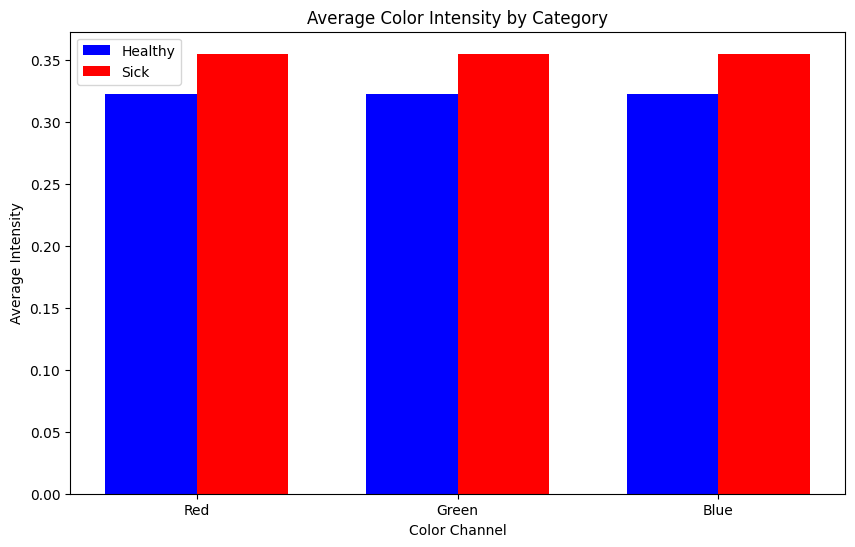

In [83]:
healthy_colors = np.mean(avg_color["Healthy"], axis=0)
sick_colors = np.mean(avg_color["Sick"], axis=0)

bar_width = 0.35
index = np.arange(3)
plt.figure(figsize=(10, 6))
plt.bar(index, healthy_colors, bar_width, label="Healthy", color='blue')
plt.bar(index + bar_width, sick_colors, bar_width, label="Sick", color='red')
plt.xlabel("Color Channel")
plt.ylabel("Average Intensity")
plt.title("Average Color Intensity by Category")
plt.xticks(index + bar_width / 2, ["Red", "Green", "Blue"])
plt.legend()
plt.show()

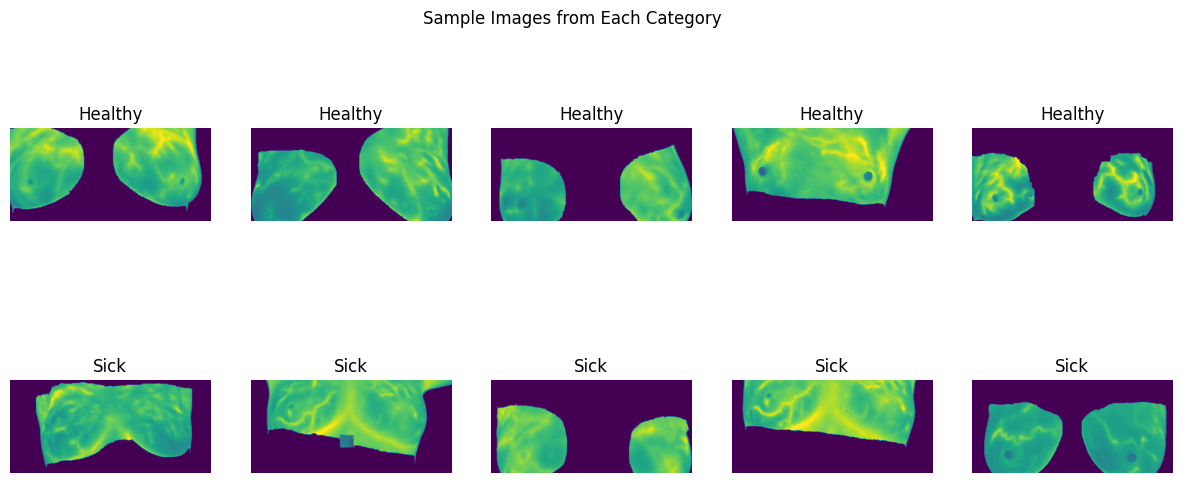

In [84]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for idx, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    sample_files = np.random.choice(os.listdir(folder_path), 5)
    for i, img_file in enumerate(sample_files):
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)
        axs[idx, i].imshow(img)
        axs[idx, i].set_title(category)
        axs[idx, i].axis('off')
plt.suptitle("Sample Images from Each Category")
plt.show()

In [85]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='binary',
    subset='validation'
)

Found 1120 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


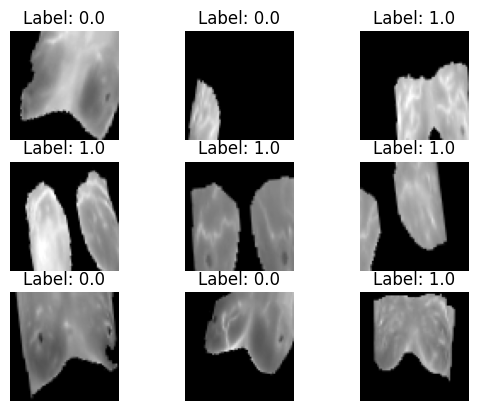

In [86]:
x_batch, y_batch = next(train_generator)
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f'Label: {y_batch[i]}')
    plt.axis('off')
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 23s 267ms/step - accuracy: 0.4956 - loss: 1.0435 - val_accuracy: 0.5000 - val_loss: 0.8605
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 263ms/step - accuracy: 0.5121 - loss: 0.8422 - val_accuracy: 0.5000 - val_loss: 0.7895
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 263ms/step - accuracy: 0.5178 - loss: 0.7811 - val_accuracy: 0.5821 - val_loss: 0.7524
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 267ms/step - accuracy: 0.5369 - loss: 0.7488 - val_accuracy: 0.6857 - val_loss: 0.7349
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 259ms/step - accuracy: 0.5475 - loss: 0.7247 - val_accuracy: 0.6071 - val_loss: 0.7235
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 261ms/step - accuracy: 0.5208 - loss: 0.7216 - val_accuracy: 0.5250 - val_loss: 0.7093
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.5456 - loss: 0.7093 - val_accuracy: 0.6000 - val_loss: 0.7165
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 266ms/step - accuracy: 0.5113 - loss: 0.7090 - val_accuracy: 0.589

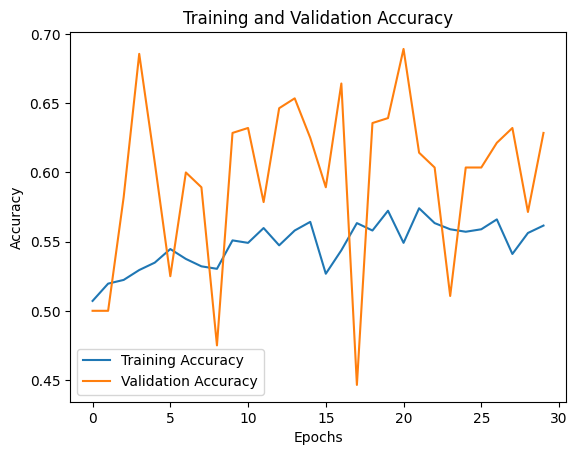

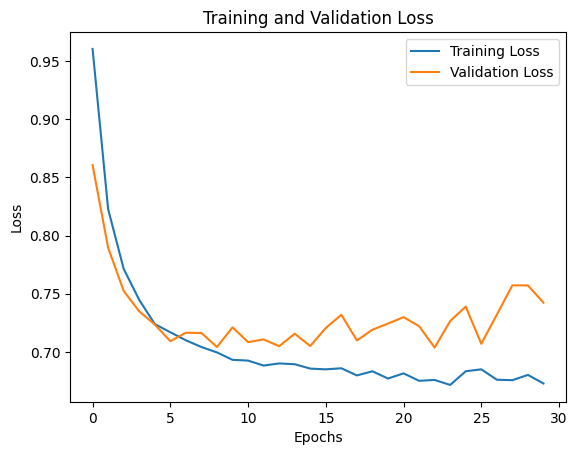

In [87]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3), kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

metrics=['accuracy']

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=30,  # Start with fewer epochs
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [88]:
datagen = ImageDataGenerator(rescale=1./255)
data_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(64, 64),        # Resize images to match model input
    batch_size=32,
    class_mode=None,             # No labels needed for clustering
    shuffle=False                # Keep order consistent
)
# Load the pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features for each image in the dataset
features = model.predict(data_generator)

Found 1400 images belonging to 2 classes.
44/44 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step


In [89]:
# Flatten features to a 2D array (num_samples, num_features)
features_reshaped = features.reshape(features.shape[0], -1)

In [90]:
from sklearn.cluster import KMeans

# Define the number of clusters (e.g., 2 for "Healthy" and "Sick")
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(features_reshaped)

# Get cluster assignments
labels = kmeans.labels_

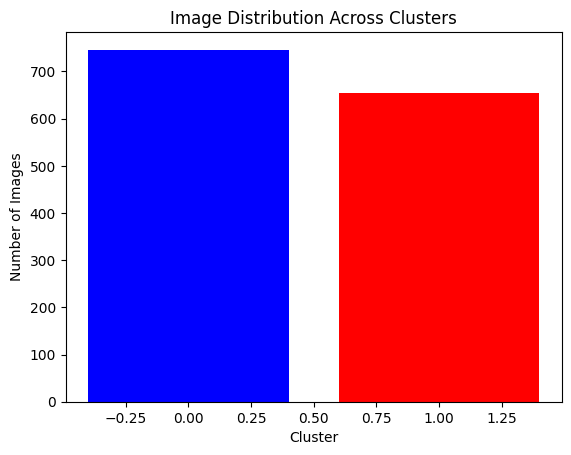

In [91]:
# Count images in each cluster
unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts, color=['blue', 'red'])
plt.xlabel("Cluster")
plt.ylabel("Number of Images")
plt.title("Image Distribution Across Clusters")
plt.show()

In [103]:
true_labels = data_generator.classes

In [104]:
from sklearn.metrics import accuracy_score
from scipy.stats import mode

In [105]:
# Get the mode of the true labels for each cluster to create a mapping
mapped_labels = np.zeros_like(labels)
for i in range(2):  # Assume 2 clusters
    mask = (labels == i)
    mapped_labels[mask] = mode(true_labels[mask])[0]

In [106]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, mapped_labels)
print(f"Clustering Accuracy: {accuracy * 100:.2f}%")

Clustering Accuracy: 57.43%


In [107]:
def clustering_accuracy(true_labels, cluster_labels):
    # Create a confusion matrix
    matrix = confusion_matrix(true_labels, cluster_labels)

    # Use linear assignment to maximize accuracy
    row_ind, col_ind = linear_sum_assignment(matrix.max() - matrix)
    accuracy = matrix[row_ind, col_ind].sum() / matrix.sum()

    return accuracy

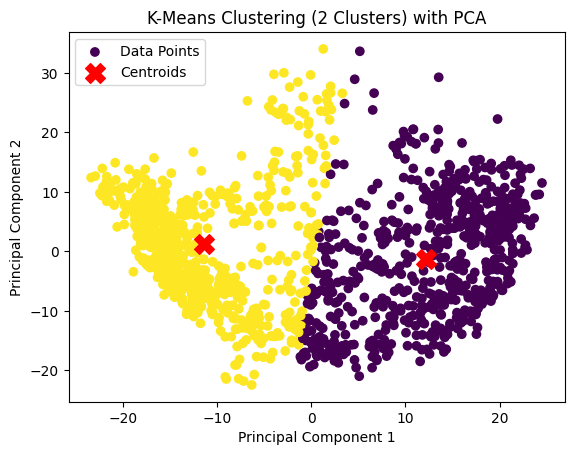

In [112]:
# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_reshaped)

# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_scaled)

# Re-run K-means on the 2D features
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(features_2d)

# Plot the results
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis', marker='o', label='Data Points')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='X', label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering (2 Clusters) with PCA')
plt.legend()
plt.show()


In [96]:
X_train, X_test, y_train, y_test = train_test_split(features_reshaped, true_labels, test_size=0.2, random_state=42)
# Initialize the KNN model (start with k=3; you can tune this later)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [97]:
# Predict on the test set
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"K-Nearest Neighbors Classification Accuracy: {accuracy * 100:.2f}%")

K-Nearest Neighbors Classification Accuracy: 96.43%


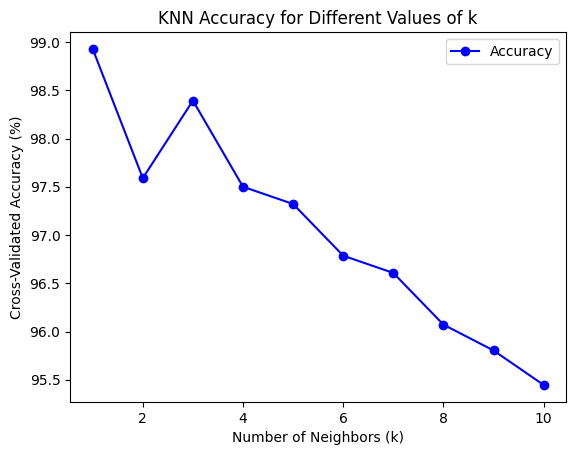

In [101]:
# Try different values of k and evaluate accuracy
k_values = range(1, 11)
accuracy_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5)  # 5-fold cross-validation
    accuracy_scores.append(scores.mean() * 100)  # Store accuracy as a percentage

# Plotting the accuracy for each k value
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy (%)')
plt.title('KNN Accuracy for Different Values of k')
plt.legend()
plt.show()